In [1]:
from functools import partial
import numpy as np
from typing import List

from pymab.policies.greedy import GreedyPolicy
from pymab.policies.contextual_bandits import ContextualBanditPolicy
from pymab.game import Game

In [2]:
def normalize_context(context: np.array) -> np.array:
    """
    Normalizes the context values to be within [0, 1].

    Args:
        context (np.array): The context array to normalize.

    Returns:
        np.array: The normalized context array.
    """
    context_min = context.min(axis=1, keepdims=True)
    context_max = context.max(axis=1, keepdims=True)
    return (context - context_min) / (context_max - context_min)

def generate_random_context(quality_levels: List[float]) -> np.array:
    """
    Generates a semi-random context for the proxy server selection considering the quality level.

    Args:
        quality_levels (List[float]): The quality levels of each proxy.

    Returns:
        np.array: Array of shape (context_dim,) with semi-random context values.
    """
    latency = [np.random.uniform(10, 200 / quality_level) for quality_level in quality_levels] # Lower latency for higher quality
    bandwidth = [np.random.uniform(10 * quality_level, 1000 * quality_level) for quality_level in quality_levels] # Higher bandwidth for higher quality
    downtime_rate = [np.random.uniform(0, 5 / quality_level) for quality_level in quality_levels] # Lower downtime for higher quality
    success_rate = [np.random.uniform(90 + quality_level * 10, 100) for quality_level in quality_levels] # Success rate range
    proximity = [np.random.uniform(1, 5000 - (1 - quality_level) * 1000) for quality_level in quality_levels] # Proximity range
    load = [np.random.uniform(0, 100 - quality_level * 100) for quality_level in quality_levels] # Load range
    # print("latency", latency)
    # print("bandwidth", bandwidth)
    # print("downtime_rate_range", downtime_rate)
    # print("success_rate_range", success_rate)
    # print("proximity_range", proximity)
    # print("load_range", load)

    context = np.array([latency, bandwidth, downtime_rate, success_rate, proximity, load])

    return normalize_context(context)

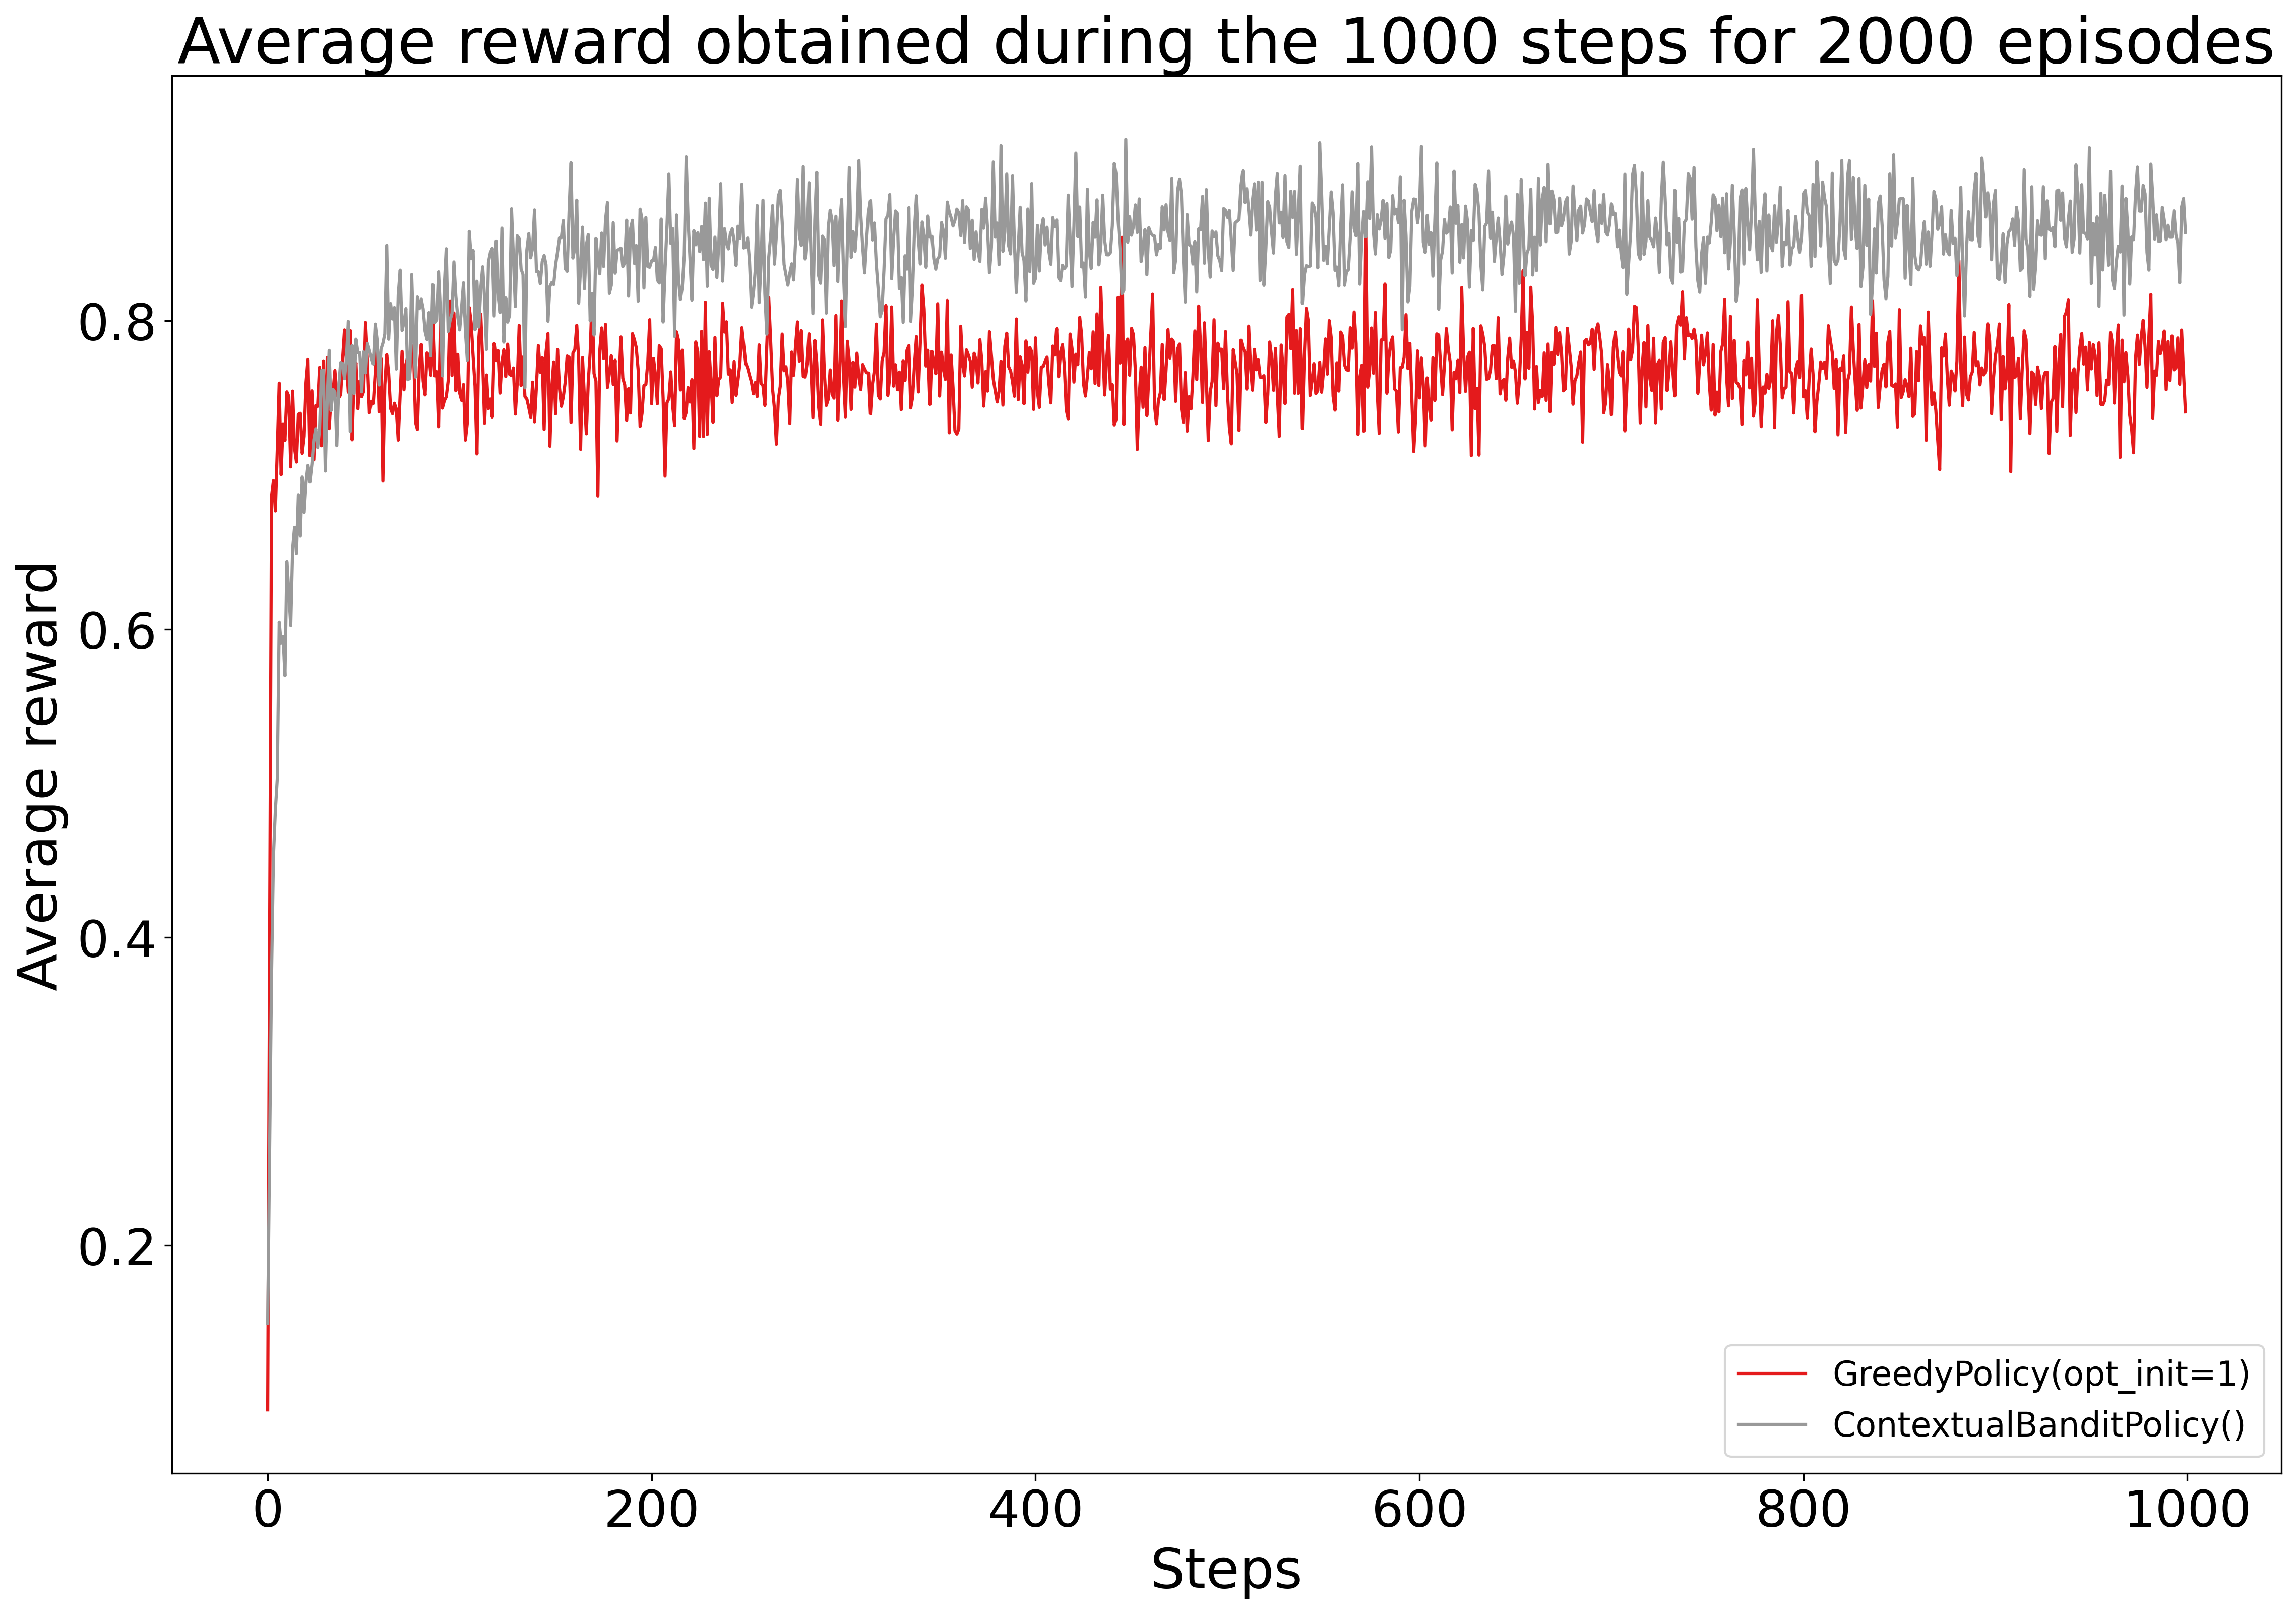

In [3]:
# Define Q-values, which are the true values of the bandits
Q_values = np.array([0.1, 0.5, 0.9])
n_bandits = 3
# Initialize the GreedyPolicy
greedy_policy = GreedyPolicy(optimistic_initialization=1,
                             n_bandits=n_bandits,)
contextual_policy = ContextualBanditPolicy(n_bandits=n_bandits,
                                           context_dim=6,
                                    context_func=partial(generate_random_context, quality_levels=Q_values))

# Setup the game
game = Game(n_episodes=2000, 
            n_steps=1000,
            Q_values=Q_values,
            policies=[greedy_policy, contextual_policy], 
            n_bandits=n_bandits,
            is_stationary=False,)

# Run the game
game.game_loop()

# Plot the results
game.plot_average_reward_by_step()